<a href="https://colab.research.google.com/github/ghoultay/Vanilla_Autoencoder_and_VAE_implementation/blob/main/autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1. Vanilla Autoencoder

## 1.1. Preparing data


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

import matplotlib.pyplot as plt
from IPython.display import clear_output

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
root = '/content/lfw-deepfunneled'
CHECKPOINTS_DIR = '/content/gdrive/MyDrive/autoencoders/'

In [ ]:
if not os.path.exists(CHECKPOINTS_DIR):
    os.makedirs(CHECKPOINTS_DIR)

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


We split the image sample into train and val, output a few images in the output to see what they look like, and cast the images to pytorch tensors so we can feed them to the network:

In [ ]:
data.shape, attrs.shape

((13143, 64, 64, 3), (13143, 73))

In [ ]:
data = data.astype(np.float32)

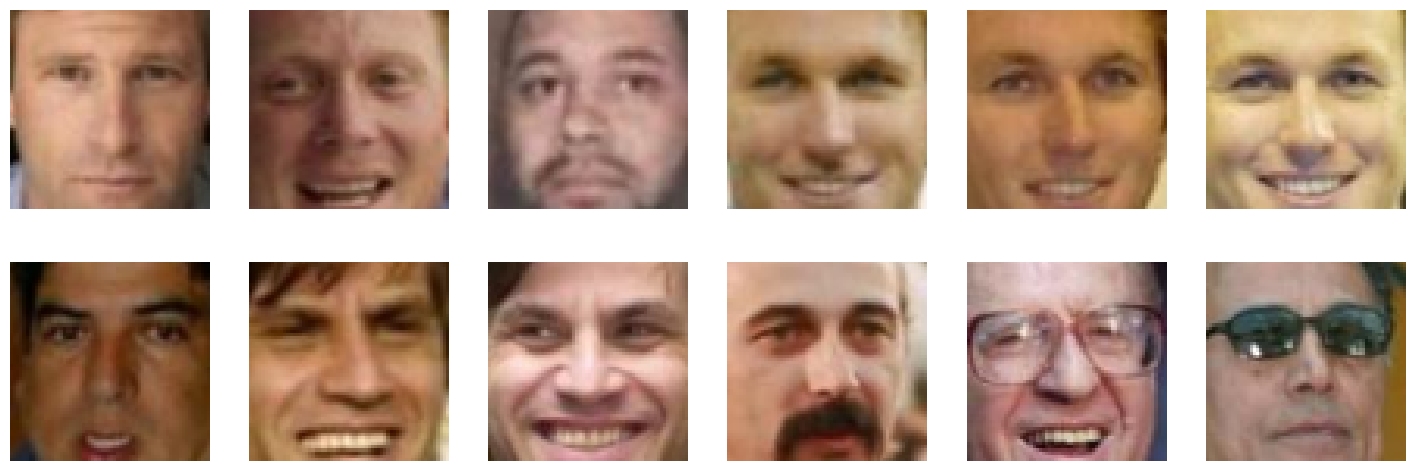

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(data[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(data[i+7])
plt.show();

In [ ]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [ ]:

# Custom dataset class for LFW
class LFWDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)

        return image  # Autoencoder: input is also the target

# Split the dataset into training and validation sets
X_train, X_val = train_test_split(
    data, test_size=0.2, random_state=42
)

# Define transformations to convert images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create custom datasets
train_dataset = LFWDataset(X_train, transform=transform)
val_dataset = LFWDataset(X_val, transform=transform)

# Create DataLoader instances for training and validation sets
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## 1.2. Model Architecture



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">

In [ ]:
dim_code = len(attrs.columns) # choosing the size of the latent vector

Implementing autoencoder

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()


        # encoder
        self.enc = nn.Sequential(
            # nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),

            nn.Flatten(),

            nn.Linear(64*64*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, dim_code)

        )

        # decoder
        self.dec = nn.Sequential(
            nn.Linear(dim_code, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64*64*3),

            nn.Unflatten(1, torch.Size([3, 64, 64])),

            # nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1),
        )
        # Обратите внимание на формат, в котором функция fetch() возвращает data

    def forward(self, x):

        latent_code = self.enc(x)
        reconstruction = self.dec(latent_code)

        return reconstruction, latent_code

In [ ]:
criterion = F.mse_loss

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

## 1.3 Training

In [ ]:
from IPython.display import clear_output
import gc

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

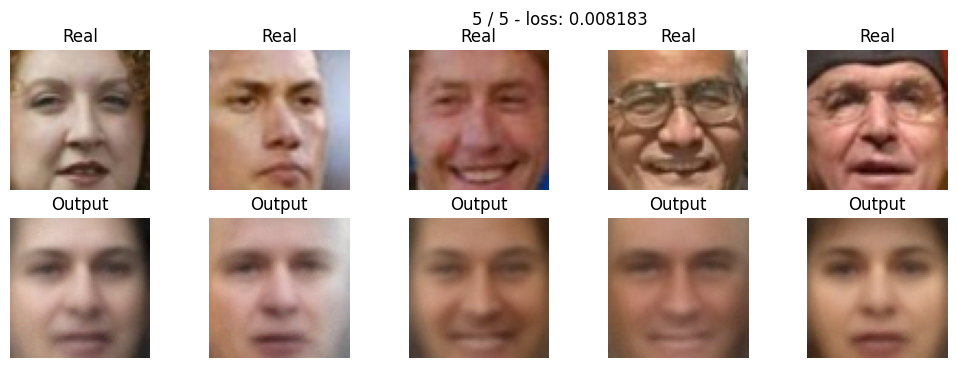

In [ ]:
n_epochs = 5

train_losses = []
val_losses = []

if torch.cuda.is_available():
  torch.cuda.empty_cache()
gc.collect()

for epoch in range(n_epochs):
    autoencoder.train()
    train_losses_per_epoch = []
    for i, X_batch, in enumerate(train_loader):
        optimizer.zero_grad()
        reconstructed, latent_code = autoencoder(X_batch.to(device))
        loss = criterion(reconstructed, X_batch.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    avg_loss = np.mean(train_losses_per_epoch)
    train_losses.append(avg_loss)

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          reconstruction, latent_code = autoencoder(X_batch.to(device))
          result = reconstruction.cpu().detach().numpy()
          ground_truth = X_batch.numpy()
          val_losses_per_epoch.append(loss.item())

        clear_output(wait=True)
        for i, (gt, res) in enumerate(zip(ground_truth[:6], result[:6])):
          plt.subplot(2, 6, i+1)
          plt.imshow(np.rollaxis(gt, 0, 3))
          plt.title('Real')
          plt.axis('off')
          plt.subplot(2, 6, i+7)
          plt.imshow(np.rollaxis(res, 0, 3))
          plt.title('Output')
          plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, n_epochs, avg_loss))
        plt.show()

    val_losses.append(np.mean(val_losses_per_epoch))


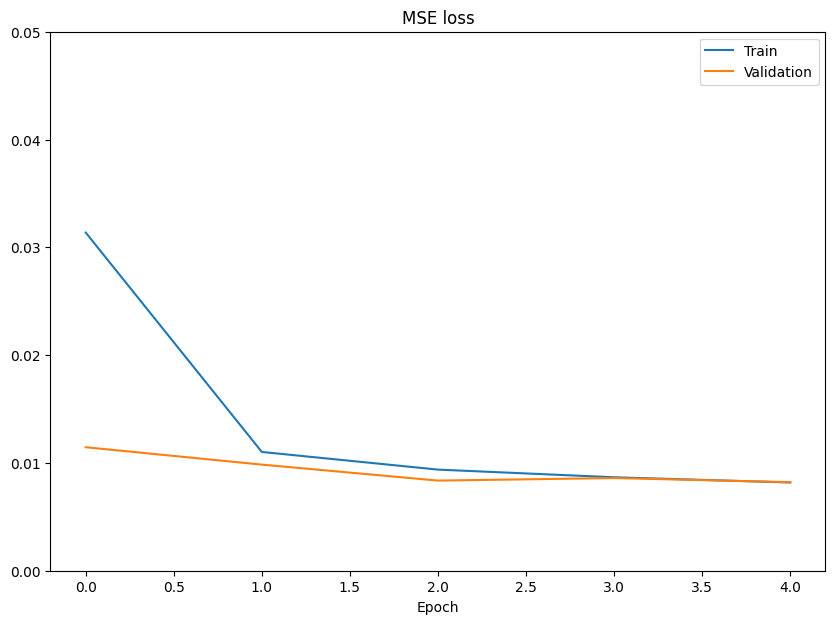

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.ylim(0, 0.05)
plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

## 1.4. Sampling

In [ ]:
import warnings
warnings.filterwarnings("ignore")

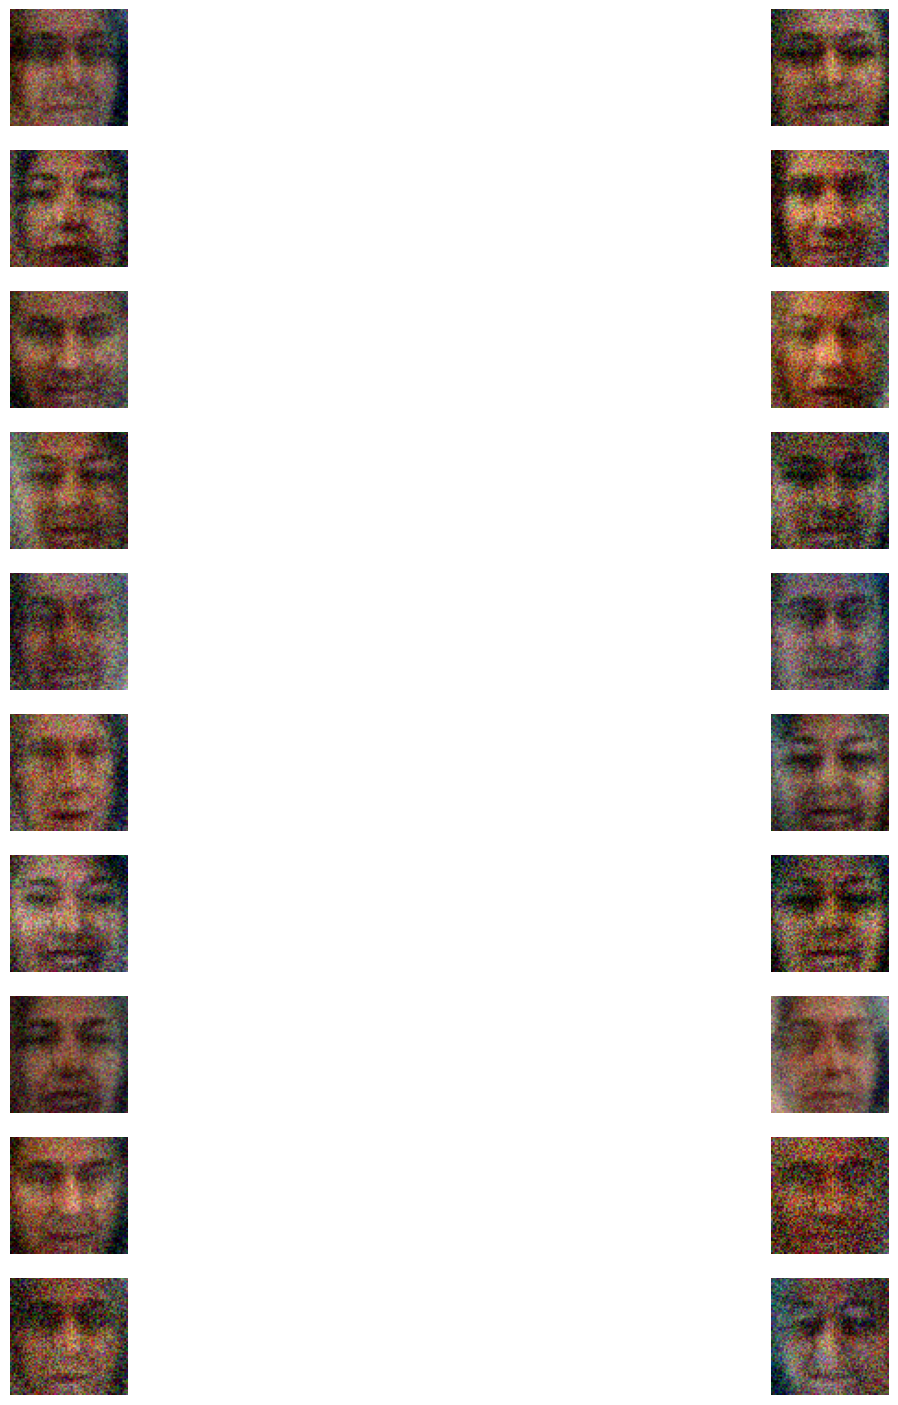

In [ ]:
# сгенерируем 20 рандомных векторов размера latent_space
z = 0.4*np.random.randn(20, dim_code) #<latent_space_dim>
output = autoencoder.dec(torch.FloatTensor(z).to(device))#<скормите z декодеру>
#<выведите тут полученные картинки>
plt.figure(figsize=(18, 18))
for i in range(output.shape[0]):
  plt.subplot(output.shape[0] // 2, 2, i + 1)
  generated = output[i].cpu().detach().numpy()
  plt.imshow(np.rollaxis(generated, 0, 3))
  plt.axis('off')

plt.show()

## 1.5 Adding smile latent vec

Let's try to put smiles on people's faces

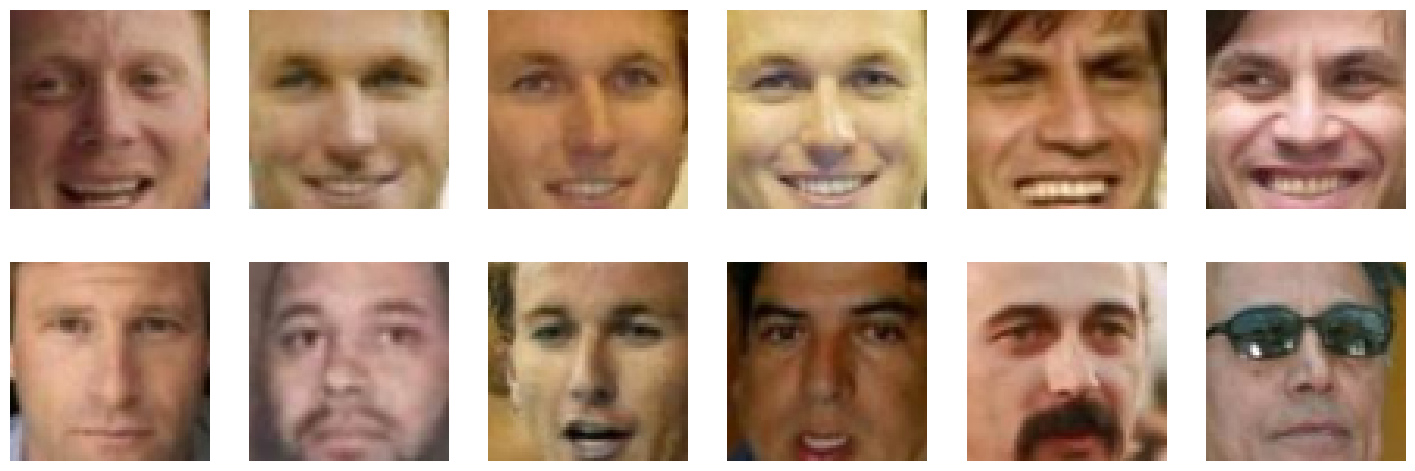

In [ ]:
plt.figure(figsize=(18, 6))
for ind,i,j in zip(range(6), attrs[attrs['Smiling'] > 0.5].index[:6] , attrs[attrs['Smiling'] <= 0.5].index[:6]):
    plt.subplot(2, 6, ind+1)
    plt.axis("off")
    plt.imshow(data[i])

    plt.subplot(2, 6, ind+7)
    plt.axis("off")
    plt.imshow(data[j])
plt.show();

In [ ]:
smile_dataset = LFWDataset(data[attrs[attrs['Smiling'] > 1].index[:100]], transform=transform)
non_smile_dataset = LFWDataset(data[attrs[attrs['Smiling'] <= 0].index[:100]], transform=transform)

smile_dataset = DataLoader(smile_dataset, batch_size=100)
non_smile_dataset = DataLoader(non_smile_dataset, batch_size=100)

In [ ]:
autoencoder.eval()
with torch.no_grad():
        for smile_batch, non_smile_batch in zip(smile_dataset,non_smile_dataset):
          _ , smile_latent_code = autoencoder(smile_batch.to(device))
          smile_latent_code = smile_latent_code.cpu().detach().numpy()
          _ , non_smile_latent_code = autoencoder(non_smile_batch.to(device))
          non_smile_latent_code = non_smile_latent_code.cpu().detach().numpy()

In [ ]:
smile_vec = torch.tensor(smile_latent_code.mean(axis = 0) - non_smile_latent_code.mean(axis = 0)).to(device)
smile_vec

tensor([-1.5192e-02, -2.2425e-02,  2.1242e-02,  6.3841e-02,  6.1475e-03,
        -3.0492e-02,  3.6084e-02,  8.2197e-02, -4.6715e-02, -7.6541e-02,
        -2.0215e-02,  1.3218e-02,  1.0608e-01, -2.8037e-02, -4.3027e-03,
         4.3606e-02,  1.1068e-02, -9.6985e-02, -3.6269e-05, -1.6444e-01,
         5.1571e-02, -7.1748e-03, -2.2030e-02,  7.3764e-02, -1.0354e-01,
        -2.8441e-02, -2.7359e-02,  5.3100e-02,  4.3028e-02,  1.8147e-02,
        -6.4319e-02, -5.2264e-02, -2.4345e-02, -1.4435e-01,  1.0005e-01,
        -3.0976e-02,  6.1886e-02, -2.1094e-02, -4.3863e-02,  7.6039e-02,
        -8.6544e-03, -1.8583e-02, -5.0586e-04, -1.6283e-02,  4.5108e-02,
         3.5471e-02,  9.5199e-02,  3.7478e-02,  5.3010e-02, -1.8588e-02,
         4.1641e-02, -5.4636e-02, -1.0289e-01,  4.1236e-02, -9.9505e-02,
         1.0431e-01,  2.2629e-02,  9.3826e-02, -1.2073e-01,  2.7694e-02,
         1.0914e-01, -2.1940e-02,  2.3671e-02, -1.6357e-02,  3.1001e-02,
        -3.1931e-02, -2.7380e-02, -8.7738e-02, -5.9

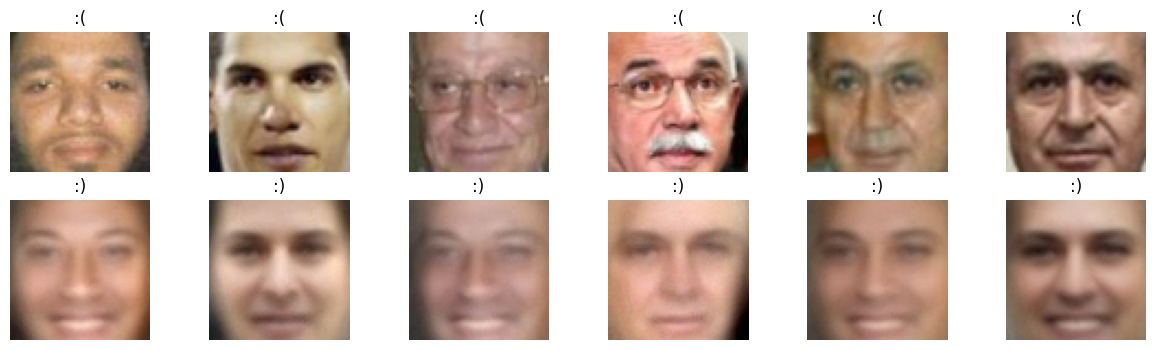

In [ ]:
non_smile_dataset = LFWDataset(data[attrs[attrs['Smiling'] <= 0.5].index[100:106]], transform=transform)
non_smile_dataset = DataLoader(non_smile_dataset, batch_size=6)

for non_smile_batch in non_smile_dataset:
    latent_code = autoencoder.enc(non_smile_batch.to(device))
    latent_code += smile_vec
    output = autoencoder.dec(latent_code.to(device)).cpu().detach().numpy()

    for i, (gt, res) in enumerate(zip(non_smile_batch, output)):
              plt.subplot(2, 6, i+1)
              plt.imshow(np.rollaxis(gt.numpy(), 0, 3))
              plt.title(':(')
              plt.axis('off')
              plt.subplot(2, 6, i+7)
              plt.imshow(np.rollaxis(res, 0, 3))
              plt.title(':)')
              plt.axis('off')
    plt.show()

# Part 2: Variational Autoencoder

Let's teach variation autoencoders - the upgraded version of AE. We will train on the MNIST dataset containing handwritten digits from 0 to 9

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 162081592.00it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 106915881.57it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 166215424.84it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20572925.24it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Model architecture and learning

In [ ]:
dim_code = 196

class VAE(nn.Module):
    def __init__(self):

        super().__init__()

        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7),

            nn.Flatten(),

            nn.Linear(64, 2*dim_code),

        )

        self.dec = nn.Sequential(

            nn.Linear(dim_code, 64),
            nn.ReLU(),

            nn.Unflatten(1, torch.Size([64, 1, 1])),

            nn.ConvTranspose2d(64, 32, kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        )

    def encode(self, x):

        x = self.enc(x)

        x = x.view(-1, 2, dim_code)

        mu = x[:, 0, :] # the first feature values as mean
        logsigma = x[:, 1, :] # the other feature values as variance

        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std)
            latent_vector = mu + eps * std

            return latent_vector
        else:
            # on inference, we return the center vector from the normal distribution, not a random vector from the normal distribution -- mu.
            # at inference, the autoencoder output must be deterministic.
            return mu

    def decode(self, z):

        x = self.dec(z)
        reconstruction = torch.sigmoid(x)

        return reconstruction

    def forward(self, x):

        mu, logsigma = self.encode(x)

        z = self.gaussian_sampler(mu, logsigma)

        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

Let's define loess and its components for VAE:

took loss from [this](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

The total loss will look like this:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Formula for KL-divergence:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

As log-likelihood we take the familiar cross-entropy.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    part of the loss function, which is responsible for the "closeness" of latent representations of different people
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    part of the loss function, which is responsible for the reconstruction quality (like mse in a regular autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

Let's train our model

In [ ]:
criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.001)

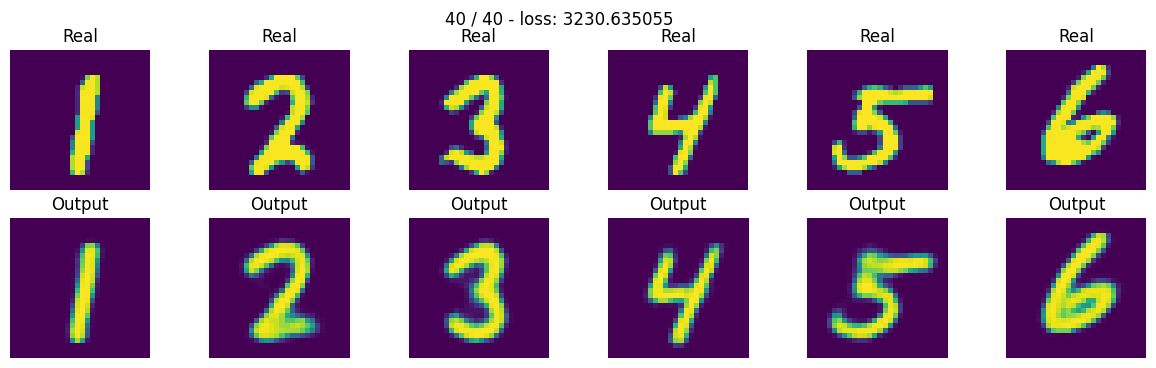

In [ ]:
n_epochs = 40

train_losses = []
val_losses = []

if torch.cuda.is_available():
  torch.cuda.empty_cache()
gc.collect()

for epoch in range(n_epochs):
    autoencoder.train()
    train_losses_per_epoch = []
    for i, (X_batch, label) in enumerate(train_loader):
        optimizer.zero_grad()
        mu, logsigma, reconstruction = autoencoder(X_batch.to(device))
        loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    avg_loss = np.mean(train_losses_per_epoch)
    train_losses.append(avg_loss)

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for (X_batch, label) in test_loader:
          mu, logsigma, reconstruction = autoencoder(X_batch.to(device))
          result = reconstruction.cpu().detach().numpy()
          ground_truth = X_batch.numpy()
          val_losses_per_epoch.append(loss.item())

        clear_output(wait=True)
        for i, (gt, res) in enumerate(zip(ground_truth[:6], result[:6])):
          plt.subplot(2, 6, i+1)
          plt.imshow(np.rollaxis(gt, 0, 3))
          plt.title('Real')
          plt.axis('off')
          plt.subplot(2, 6, i+7)
          plt.imshow(np.rollaxis(res, 0, 3))
          plt.title('Output')
          plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, n_epochs, avg_loss))
        plt.show()

    val_losses.append(np.mean(val_losses_per_epoch))


Let's take a look at how our trained VAE encodes and reconstructs pictures:

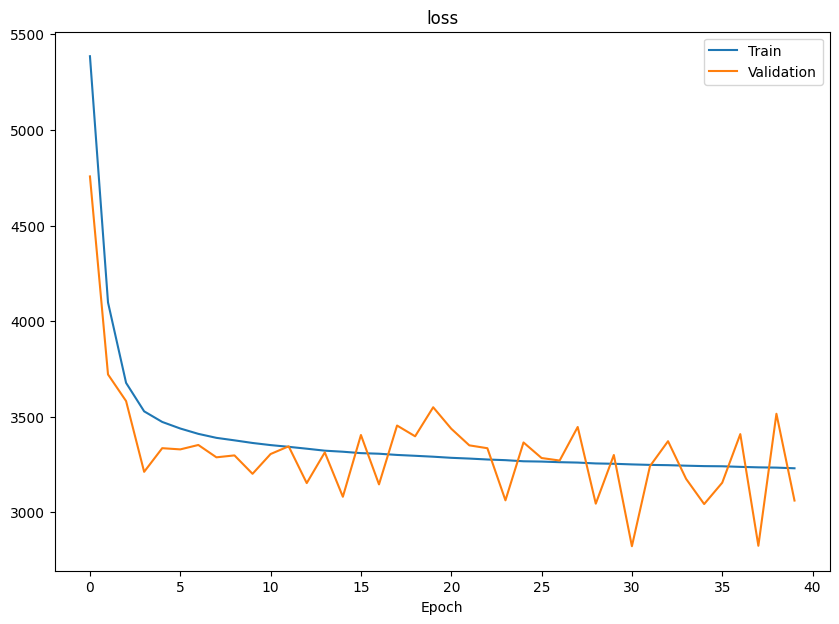

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('loss')
plt.legend()
plt.show()

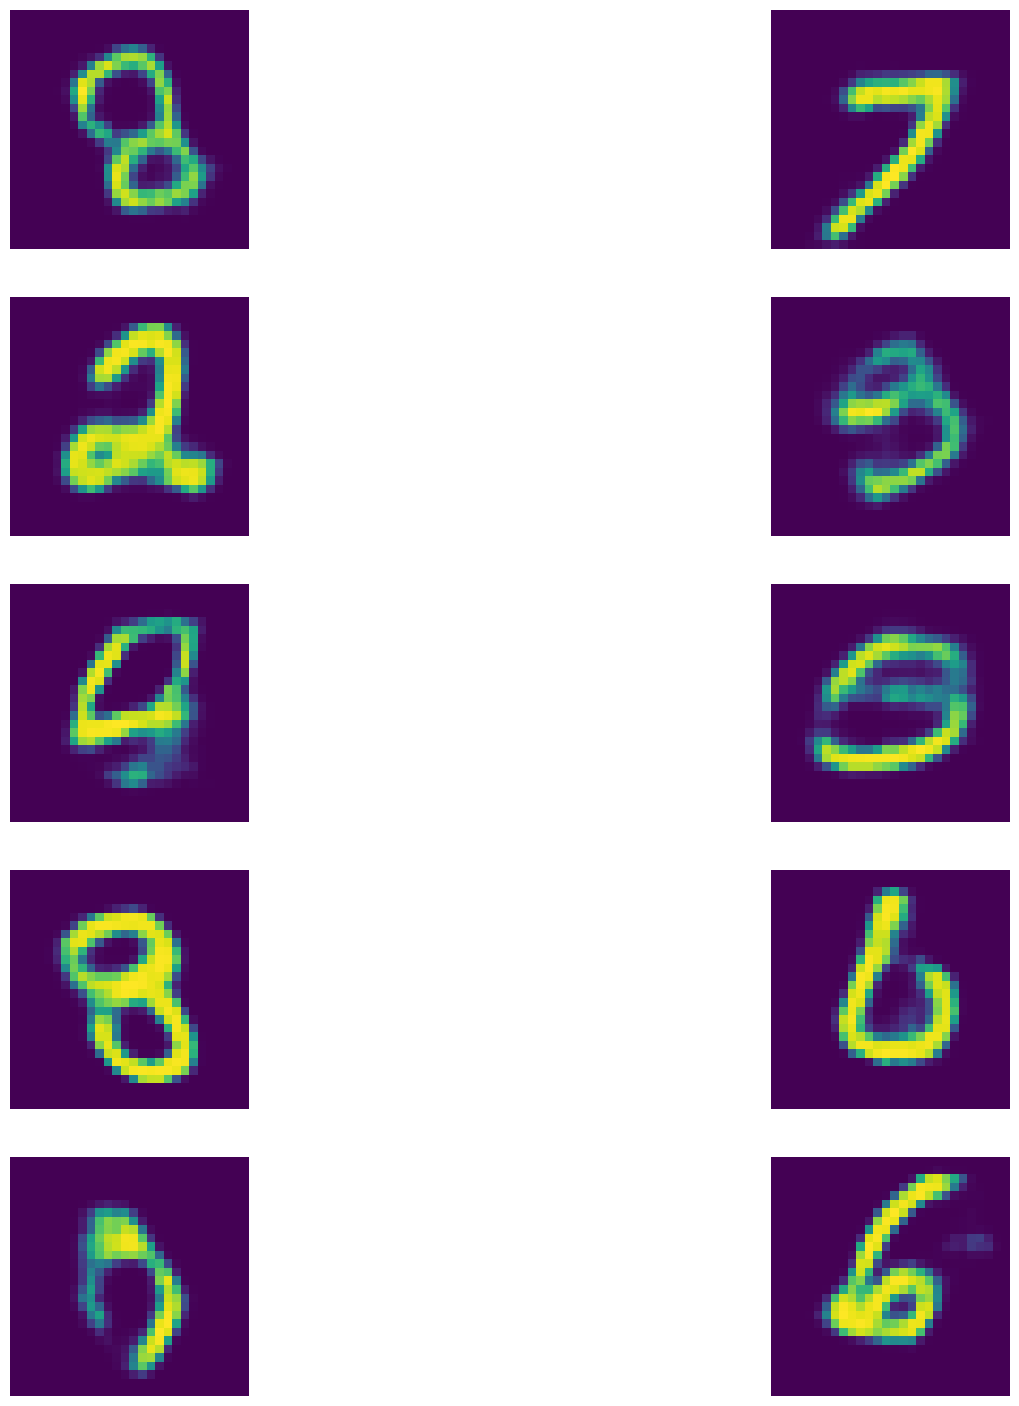

In [ ]:
z = np.array([np.random.normal(0, 1, dim_code) for i in range(10)])
output = autoencoder.decode(torch.FloatTensor(z).to(device))
plt.figure(figsize=(18, 18))
for i in range(output.shape[0]):
  plt.subplot(output.shape[0] // 2, 2, i + 1)
  generated = output[i].cpu().detach().numpy()
  plt.imshow(np.rollaxis(generated, 0, 3))
  plt.axis('off')

plt.show()

## 2.2. Latent Representation

In [ ]:
autoencoder.eval()
with torch.no_grad():
  test_latent_vectors = np.array([])
  labels = np.array([])
  for (X_batch, label) in test_loader:
      mu, logsigma = autoencoder.encode(X_batch.to(device))
      latent_vec = autoencoder.gaussian_sampler(mu, logsigma).cpu().detach().numpy()
      if not test_latent_vectors.any() :
        test_latent_vectors = latent_vec
      else:
        test_latent_vectors = np.vstack((test_latent_vectors, latent_vec))
      labels = np.append(labels,label)
test_latent_vectors.shape, labels.shape

((10000, 196), (10000,))

In [ ]:
from sklearn.manifold import TSNE

vec_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(test_latent_vectors)
vec_embedded.shape

(10000, 2)

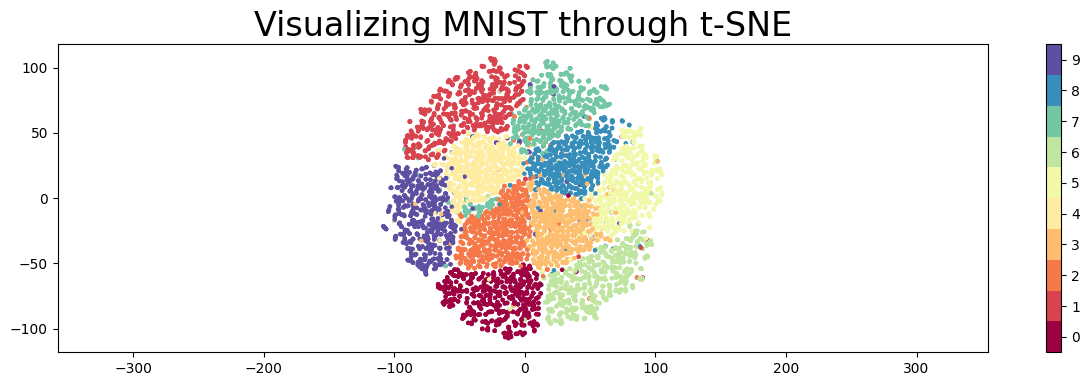

In [ ]:
plt.scatter(vec_embedded[:, 0], vec_embedded[:, 1], s= 5, c=labels, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Visualizing MNIST through t-SNE', fontsize=24);